Following document and takes what I need.

# Creating the Hamiltonian

In [16]:
# Single ground state and an excited state with some detuning 
import numpy as np
import pylcp

delta = 1
mass = 1
Hg = np.array([[0.]]) # create 2 dimension array (since Hamiltonian is matrix of submatrix) but contain 1x1 matrix now since we're dealing 
He = np.array([[-delta]])
# mu, d are defined as spherical harmonics.
# It defined as 3 dimension, 1x1 matrix
# first element being the q = -1, the second q = 0, and the third q = 1
mu_q = np.zeros((3,1,1))
d_q = np.zeros((3,1,1))
d_q[1,0,0] = 1.

# There are shpae requirement.
hamiltonian = pylcp.hamiltonian(Hg, He, mu_q, mu_q, d_q, mass=mass)


# Laser beams

In [17]:
norm_intensity = 1 # ratio of saturation power.
laserBeams = pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 's':norm_intensity},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 's':norm_intensity}
        ], beam_type=pylcp.infinitePlaneWaveBeam)

# Magnetic field and Governing equation

In [3]:
alpha = 1 # gradient ratio
magField = pylcp.quadrupoleMagneticField(alpha)
obe = pylcp.obe(laserBeams, magField, hamiltonian)
v = np.arange(-10.,10.1, 0.1)
profile = obe.generate_force_profile(np.zeros((3,)+v.shape), [v, np.zeros(v.shape), np.zeros(v.shape)])

# $F=2\rightarrow F=3$ 1D molasses


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pylcp
import scipy.constants as cts
from pylcp.common import progressBar
import lmfit


In [2]:
# Define the problem
atom = pylcp.atom('87Rb')
# transition.k is in cm
# dimensionless mass is gamma * M / k^2 * hbar
# state[2] is D2 line
# transition[1] corresponds to D2 transition.
# We're dealing with manifold now.
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
print(mass)

804.3755599734405


In [3]:
# Here the document create methods to return the hamiltonian and the lasers in order to sweep their parameters.
# Note that the magnetic field is always zero
# They make a dictionary of different polarizations that they will expolore.
def return_hamiltonian(Fl, Delta):
    # .singleF construct the hamiltonian for a lonely angular momentum state.
    # This works becuase we're dealing with optical molasses? basically no magnetic field.-> degenerate
    # In this example, we don't need to set gF, but just for physical correctnnes
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl, (Fl+1))
    # Note how to use np.eye
    # The reason why we're using Delta is that we're in RF.
    hamiltonian = pylcp.hamiltonian(Hg, -Delta*np.eye(He.shape[0])+He, Bgq, Beq, dijq, mass = mass)
    
    return hamiltonian

# Define 1D laser beams
def return_lasers(delta, s, pol):
    # Look at the pol setup below (defined dictionary)
    # Here, we set counter propagating light configuration.
    if pol[0][2]>0 or pol[0][1]>0:
        pol_coord = 'spherical'
    else:
        pol_coord = 'cartesian'
    return pylcp.laserBeams([
            {'kvec':np.array([0., 0., 1.]), 'pol':pol[0],
             'pol_coord':pol_coord, 'delta':delta, 's':s},
            {'kvec':np.array([0., 0., -1.]), 'pol':pol[1],
             'pol_coord':pol_coord, 'delta':delta, 's':s},
            ], beam_type=pylcp.infinitePlaneWaveBeam)

magField = pylcp.constantMagneticField(np.array([0.,0.,0.]))

pols = {'$\\sigma^+\\sigma^-$':[np.array([0.,0.,1.]), np.array([1., 0., 0.])],
        '$\\sigma^+\\sigma^+$':[np.array([0., 0., 1.]), np.array([0., 0., 1.])]}

# This line is for adding counter-linear polarization setup.
# Note that in this case, laserbeam configuration is cartesian (along x-axis).
phi = [0, np.pi/4, np.pi/2]
phi_keys = ['$\\phi=0$', '$\\phi=\\pi/4$', '$\\phi=\\pi/2$']
for phi_i, key_beam in zip(phi, phi_keys):
        pols[key_beam] = [np.array([1., 0., 0.]), np.array([np.cos(phi_i), np.sin(phi_i), 0.])]
    

In [4]:
det = -2.5
s = 1.0

hamiltonian = return_hamiltonian(2, det)

v = np.concatenate((np.arange(0.001, 0.01, 0.001),
                    np.arange(0.01, 0.02, 0.002),
                    np.arange(0.02, 0.03, 0.005),
                    np.arange(0.03, 0.1, 0.01),
                    np.arange(0.1, 5.1, 0.1)))

obe = {}
for key_beam in pols:
    laserBeams = return_lasers(0., s, pol=pols[key_beam])

    obe[key_beam] = pylcp.obe(
        laserBeams, magField, hamiltonian,
        include_mag_forces=False, transform_into_re_im=True
    )

    obe[key_beam].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
        rel=1e-8, abs=1e-10, progress_bar=True
    )

Completed in 1:57.                                                  
Completed in 52.72 s.                                               
Completed in 1:46.                                                  
Completed in 1:50.                                                  
Completed in 2:03.                                                  


/var/folders/mz/llnnp3cx7n3_w9l4t55w8zn80000gn/T/ipykernel_78714/3340789849.py:9: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(np.concatenate((-v[::-1], v)),
/var/folders/mz/llnnp3cx7n3_w9l4t55w8zn80000gn/T/ipykernel_78714/3340789849.py:15: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axins.plot(np.concatenate((-v[::-1], v)),


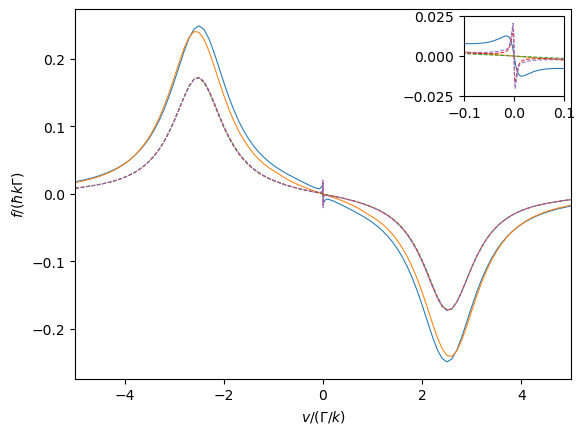

In [5]:
fig, ax = plt.subplots(1, 1)
axins = inset_axes(ax, width=1.0, height=0.8)
for key in obe:
    if 'phi' in key:
        linestyle='--'
    else:
        linestyle='-'

    ax.plot(np.concatenate((-v[::-1], v)),
            np.concatenate((-obe[key].profile['molasses'].F[2][::-1],
                            obe[key].profile['molasses'].F[2])),
            label=pols[key], linestyle=linestyle,
            linewidth=0.75
            )
    axins.plot(np.concatenate((-v[::-1], v)),
               np.concatenate((-obe[key].profile['molasses'].F[2][::-1],
                               obe[key].profile['molasses'].F[2])),
            label=pols[key], linestyle=linestyle,
            linewidth=0.75
            )

ax.set_xlim(-5, 5)
ax.set_xlabel('$v/(\\Gamma/k)$')
ax.set_ylabel('$f/(\\hbar k \\Gamma)$')

axins.set_xlim(-0.1, 0.1)
axins.set_ylim(-0.025, 0.025);

# Simulate many atoms and find the temperature

In [13]:
tmax = 1e4
det = -2.73
s = 1.25
key =  '$\\sigma^+\\sigma^-$'

laserBeams = return_lasers(0., s, pol=pols[key])
hamiltonian = return_hamiltonian(2, det)

obe = pylcp.obe(laserBeams, magField, hamiltonian,
                include_mag_forces=False)

obe.set_initial_position(np.array([0., 0., 0.]))
obe.set_initial_velocity(np.array([0., 0., 0.]))
obe.set_initial_rho_equally()

obe.evolve_motion(
    [0, tmax],
    t_eval=np.linspace(0, tmax, 501),
    random_recoil=True,
    events=(),
    progress_bar=True,
    max_scatter_probability=0.5,
    record_force=True,
    freeze_axis=[True, True, False]
);

Completed in 7.24 s.                                                


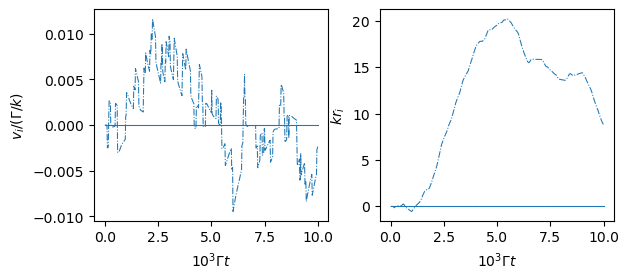

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ll = 0
styles = ['-', '--', '-.']
for jj in range(3):
    ax[0].plot(obe.sol.t/1e3,
               obe.sol.v[jj], styles[jj],
               color='C%d'%ll, linewidth=0.75)
    ax[1].plot(obe.sol.t/1e3,
               obe.sol.r[jj],
               styles[jj], color='C%d'%ll, linewidth=0.75)

#ax[1].set_ylim(-5., 5.)
ax[0].set_ylabel('$v_i/(\Gamma/k)$')
ax[1].set_ylabel('$k r_i$')
ax[0].set_xlabel('$10^{3} \Gamma t$')
ax[1].set_xlabel('$10^{3} \Gamma t$')
fig.subplots_adjust(left=0.1, wspace=0.22)

In [18]:
import pathos
if hasattr(obe, 'sol'):
    del obe.sol

t_eval = np.linspace(0, tmax, 5001)

def generate_random_solution(x, tmax=1e4):
    # We need to generate random numbers to prevent solutions from being seeded
    # with the same random number.
    np.random.rand(256*x)
    obe.set_initial_position(np.array([0., 0., 0.]))
    obe.set_initial_velocity(np.array([0., 0., 0.]))
    obe.set_initial_rho_equally()
    obe.evolve_motion(
        [0, tmax],
        t_eval=t_eval,
        random_recoil=True,
        events=(),
        max_scatter_probability=0.5,
        record_force=True,
        freeze_axis=[True, True, False]
    )

    return obe.sol

Natoms = 96
chunksize = 4
sols = []
progress = progressBar()
for jj in range(int(Natoms/chunksize)):
    with pathos.pools.ProcessPool(nodes=4) as pool:
        sols += pool.map(generate_random_solution, range(chunksize))
    progress.update((jj+1)/int(Natoms/chunksize))

Completed in 3:04.                                                  


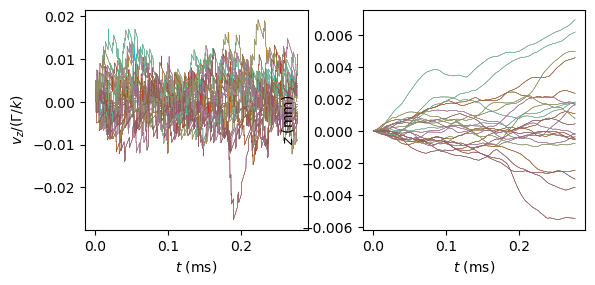

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(6.25, 2.75))

for sol in sols:
    ax[0].plot(sol.t*atom.state[1].tau*1e3,
               sol.v[2], linewidth=0.25)
    ax[1].plot(sol.t*atom.state[1].tau*1e3,
               sol.r[2]/(2*np.pi*0.1*atom.transition[1].k), linewidth=0.25)

for ax_i in ax:
    ax_i.set_xlabel('$t$ (ms)')
ax[0].set_ylabel('$v_z/(\Gamma/k)$')
ax[1].set_ylabel('$z$ (mm)')

fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.25)

In [1]:
vs = np.array([sol.v[2] for sol in sols])

xb = np.arange(-0.1, 0.1, 0.005)
fig, ax = plt.subplots(1, 1)
ax.hist(vs[:, 1000::250].flatten(), bins=xb)
x = xb[:-1] + np.diff(xb)/2
y = np.histogram(vs[:, 1000::250].flatten(), bins=xb)[0]

model = lmfit.models.GaussianModel(prefix='A_')# + lmfit.models.GaussianModel(prefix='B_')

params = model.make_params()
params['A_sigma'].value = 0.05
#params['B_sigma'].value = 0.01

ok = y>0
result = model.fit(y[ok], params, x=x[ok], weights=1/np.sqrt(y[ok]))

x_fit = np.linspace(-0.1, 0.1, 101)
ax.plot(x_fit, result.eval(x=x_fit))
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('Counts')
print('Temperature: %.1f uK'%(2*result.best_values['A_sigma']**2*mass*cts.hbar*atom.state[2].gamma/2/cts.k*1e6))
result

NameError: name 'np' is not defined

In [5]:
from scipy.spatial.transform import Rotation

rot_mat = Rotation.from_euler('Z', 0.).as_matrix()
print(type(rot_mat))


<class 'numpy.ndarray'>
